In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (8,6)
%config InlineBackend.figure_format='retina' 

#加载数据
def load_data(path):
    f = np.load(path) 
    x_train,y_train,x_test,y_test = f['x_train'], f['y_train'], f['x_test'],f['y_test']
    f.close()
    return x_train, y_train, x_test, y_test

#将标签转化为独热形式
def one_hot_y(arr):
    arr_zero = np.zeros((arr.size,10))
    arr_zero[np.arange(arr.size),arr] = 1
    return arr_zero

#定义sigmoid函数
def sigmoid(x):
    return 1/(1+np.exp(-x))

#定义softmax函数
def softmax(x):
    #进行转置，避免内存溢出
    x = x.T
    y = np.exp(x)/np.sum(np.exp(x), axis=0)
    return y.T

#对训练集求交叉熵损失函数,t是已知值，y是输出的概率
def cross_entropy_error(y, t):
    cost_arr = - t * np.log(y+1e-7)     #避免概率0的出现，无法求对数
    cost = cost_arr.sum()
    return cost

#定义sigmoid的导数
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

#定义模型
class Network:

    def __init__(self,input_size,hidden_size,output_size,weight_init_std=0.01):
        #初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std*np.random.randn(input_size,hidden_size)
        self.params['b1'] = np.zeros((hidden_size))
        self.params['W2'] = weight_init_std*np.random.randn(hidden_size,output_size)
        self.params['b2'] = np.zeros(output_size)
    
    #预测每个数字的概率
    def predict(self,x):
        #向前传播
        W1,W2 = self.params['W1'],self.params['W2']
        b1,b2 = self.params['b1'],self.params['b2']

        a1 = np.dot(x,W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1,W2) + b2
        y = softmax(a2)

        return y

    #计算损失函数
    def loss(self,x,t):
        y = self.predict(x)

        return cross_entropy_error(y,t)

    #对测试集求分类准确率
    def accuracy(self,x,t):
        y = self.predict(x)
        t_max_arr = np.argmax(t,axis=1)
        y_max_arr = np.argmax(y,axis=1)
        rate = np.equal(t_max_arr,y_max_arr).sum()/len(y_max_arr)
        
        return rate
    
    #误差反向传播求梯度 
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}

        batch_num = x.shape[0]

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        # 反向传播
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)

        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [2]:
# 调用load_data函数加载数据集
path = r'mnist.npz'
x_train_npz, t_train_npz, x_test_npz, t_test_npz = load_data(path)

#对输入集进行降维并归一化
x_train = x_train_npz.reshape(60000,28*28)/255
x_test = x_test_npz.reshape(10000,28*28)/255
#将标签转化为one-hot
t_train = one_hot_y(t_train_npz)
t_test = one_hot_y(t_test_npz)

# 查看数据集的形状
print('x_train:{}'.format(x_train.shape))
print('t_train:{}'.format(t_train.shape))
print('x_test:{}'.format(x_test.shape))
print('t_test:{}'.format(t_test.shape))

x_train:(60000, 784)
t_train:(60000, 10)
x_test:(10000, 784)
t_test:(10000, 10)


In [3]:
# 超参数
iters_num = 20000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
gamma = 0.99   #学习率衰减指数

learning_rate_list = [learning_rate]
train_loss_list = []
train_acc_list = []
test_acc_list = []
per_epoch = max(train_size/batch_size,1)    #60000/100=600，做600次mini_batch形成一个epoch,一共经历了20000/600个epoch

# 创建网络
network = Network(input_size=784,hidden_size=50,output_size=10)

#进行一万次mini_batch的训练
for i in range(iters_num):  
    
    if ((i+1) % 1000 == 0):
        print("********已经完成"+str(i+1)+"次mini_batch...")

    #SGD，每次随机选择100个样本
    batch_num = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_num]
    t_batch = t_train[batch_num]

    #计算梯度
    grad = network.gradient(x_batch, t_batch)
    
    #指数衰减调整学习率
    if (i+1) % per_epoch == 0 :
        learning_rate = learning_rate * gamma**((i+1)/per_epoch)
        learning_rate_list.append(learning_rate)
    
    # 更新参数
    for key in ('W1','b1','W2','b2'):
        network.params[key] -=learning_rate*grad[key]

    # 记录损失函数
    loss = network.loss(x_batch,t_batch)
    train_loss_list.append(loss)

    #记录每次epoch的准确率
    if (i+1) % per_epoch == 0 :
        train_acc = network.accuracy(x_train,t_train)
        test_acc = network.accuracy(x_test,t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
print('********运行结束')

********已经完成1000次mini_batch...
********已经完成2000次mini_batch...
********已经完成3000次mini_batch...
********已经完成4000次mini_batch...
********已经完成5000次mini_batch...
********已经完成6000次mini_batch...
********已经完成7000次mini_batch...
********已经完成8000次mini_batch...
********已经完成9000次mini_batch...
********已经完成10000次mini_batch...
********已经完成11000次mini_batch...
********已经完成12000次mini_batch...
********已经完成13000次mini_batch...
********已经完成14000次mini_batch...
********已经完成15000次mini_batch...
********已经完成16000次mini_batch...
********已经完成17000次mini_batch...
********已经完成18000次mini_batch...
********已经完成19000次mini_batch...
********已经完成20000次mini_batch...
********运行结束


初始学习率：0.1
经历第1次epoch，此时学习率为0.099
经历第2次epoch，此时学习率为0.0970299
经历第3次epoch，此时学习率为0.0941480149401
经历第4次epoch，此时学习率为0.09043820750088044
经历第5次epoch，此时学习率为0.08600583546412884
经历第6次epoch，此时学习率为0.08097278682212584
经历第7次epoch，此时学习率为0.07547192872036325
经历第8次epoch，此时学习率为0.06964132180495736
经历第9次epoch，此时学习率为0.0636185486063871
经历第10次epoch，此时学习率为0.05753547499769285
经历第11次epoch，此时学习率为0.05151371174238034
经历第12次epoch，此时学习率为0.04566097477439146
经历第13次epoch，此时学习率为0.04006846529515406
经历第14次epoch，此时学习率为0.03480931144924421
经历第15次epoch，此时学习率为0.029938039131233135
经历第16次epoch，此时学习率为0.025490976069630928
经历第17次epoch，此时学习率为0.021487444770607954
经历第18次epoch，此时学习率为0.017931568359471056
经历第19次epoch，此时学习率为0.01481449915475795
经历第20次epoch，此时学习率为0.012116881635704839
经历第21次epoch，此时学习率为0.009811376736368595
经历第22次epoch，此时学习率为0.007865099717364836
经历第23次epoch，此时学习率为0.006241855477982411
经历第24次epoch，此时学习率为0.004904089407128574
经历第25次epoch，此时学习率为0.003814505489267703
经历第26次epoch，此时学习率为0.002937333806646734
经历第27次epoch，此时学习率为0.002239255

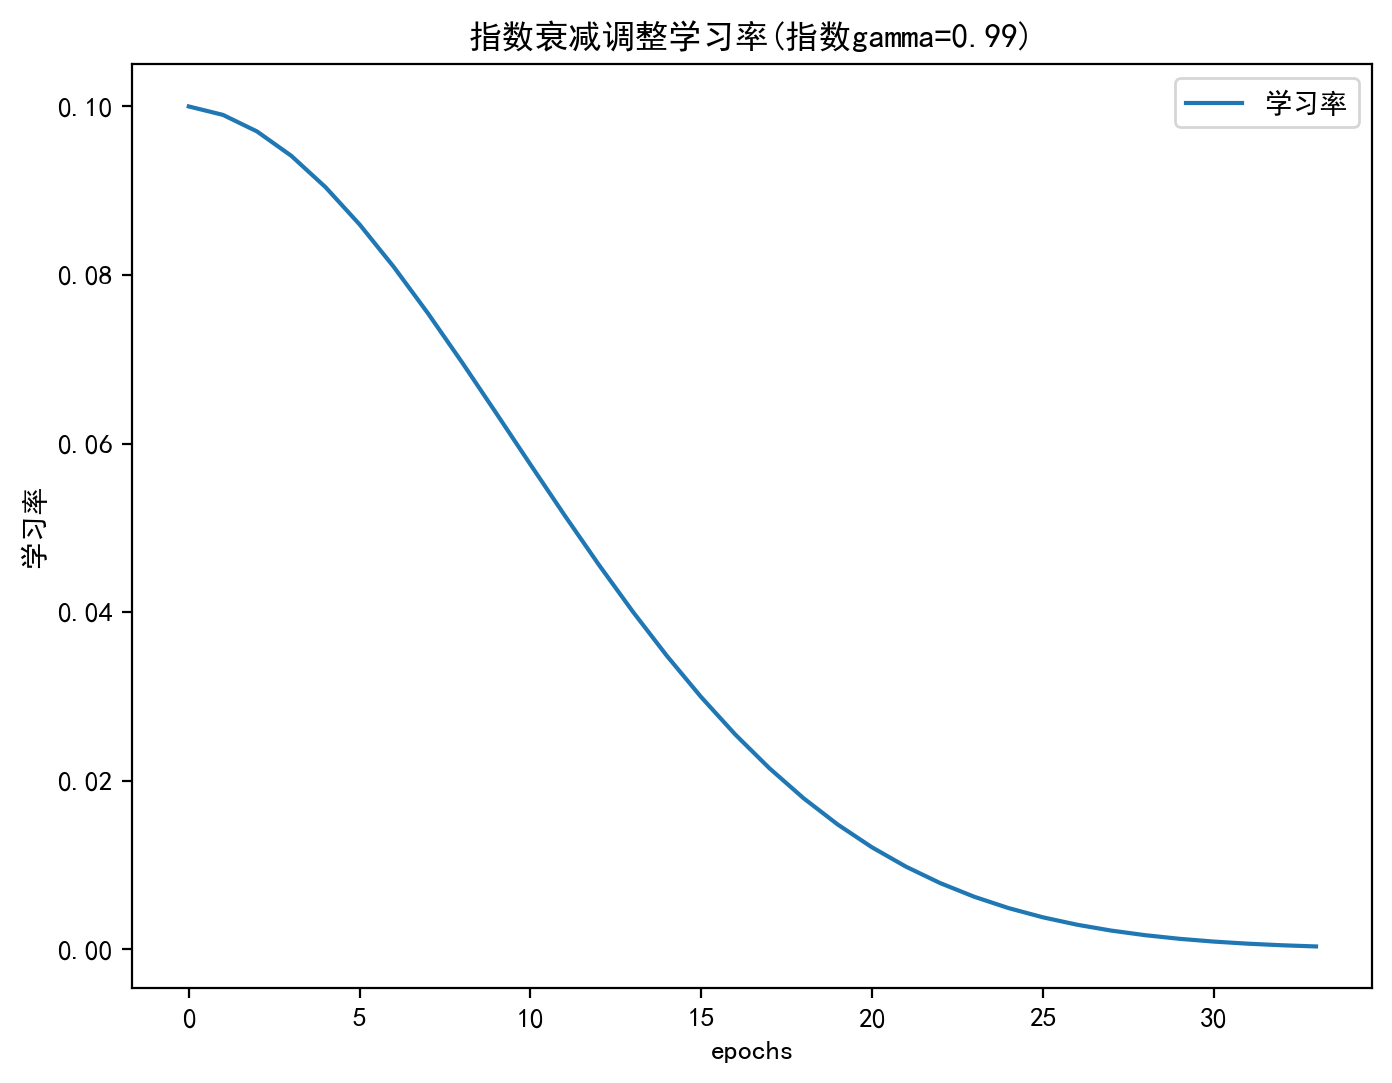

In [4]:
print(f'初始学习率：{learning_rate_list[0]}')
for i in range(len(learning_rate_list[1:])):
    print(f"经历第{(i+1)}次epoch，此时学习率为{learning_rate_list[1:][i]}")

#绘制学习率衰减曲线
plt.plot(np.arange(0,len(learning_rate_list)),learning_rate_list,label='学习率')
plt.xlabel('epochs')
plt.ylabel('学习率')
plt.title('指数衰减调整学习率(指数gamma=0.99)')
plt.legend()
plt.show()

经历第1次epoch，此时训练集准确率 = 0.77357, 测试集准确率 = 0.7791
经历第2次epoch，此时训练集准确率 = 0.87955, 测试集准确率 = 0.8821
经历第3次epoch，此时训练集准确率 = 0.89897, 测试集准确率 = 0.901
经历第4次epoch，此时训练集准确率 = 0.90833, 测试集准确率 = 0.9125
经历第5次epoch，此时训练集准确率 = 0.91462, 测试集准确率 = 0.9171
经历第6次epoch，此时训练集准确率 = 0.9189, 测试集准确率 = 0.9219
经历第7次epoch，此时训练集准确率 = 0.92288, 测试集准确率 = 0.9245
经历第8次epoch，此时训练集准确率 = 0.92583, 测试集准确率 = 0.9287
经历第9次epoch，此时训练集准确率 = 0.92837, 测试集准确率 = 0.9294
经历第10次epoch，此时训练集准确率 = 0.93045, 测试集准确率 = 0.9302
经历第11次epoch，此时训练集准确率 = 0.93258, 测试集准确率 = 0.934
经历第12次epoch，此时训练集准确率 = 0.93423, 测试集准确率 = 0.9347
经历第13次epoch，此时训练集准确率 = 0.93593, 测试集准确率 = 0.9359
经历第14次epoch，此时训练集准确率 = 0.93667, 测试集准确率 = 0.9378
经历第15次epoch，此时训练集准确率 = 0.93735, 测试集准确率 = 0.9382
经历第16次epoch，此时训练集准确率 = 0.93827, 测试集准确率 = 0.9381
经历第17次epoch，此时训练集准确率 = 0.93908, 测试集准确率 = 0.9392
经历第18次epoch，此时训练集准确率 = 0.93948, 测试集准确率 = 0.9388
经历第19次epoch，此时训练集准确率 = 0.93967, 测试集准确率 = 0.9402
经历第20次epoch，此时训练集准确率 = 0.94027, 测试集准确率 = 0.9403
经历第21次epoch，此时训练集准确率 = 0.94043, 测试集准确率 = 0.9402
经历第2

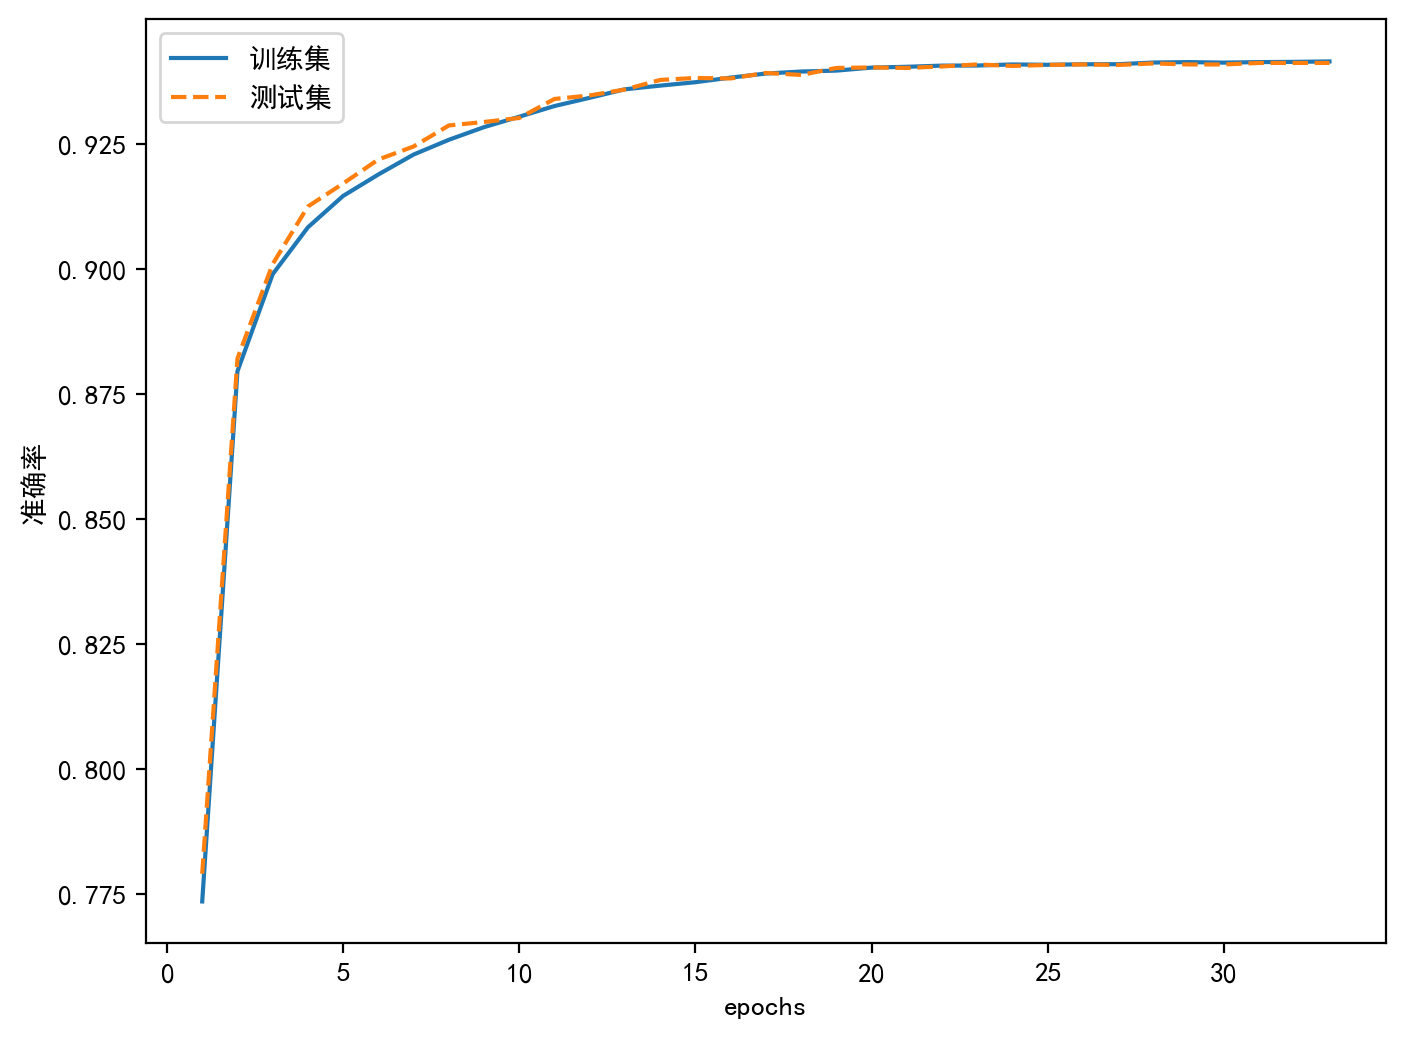

In [5]:
for i in range(len(train_acc_list)):
    print(f'经历第{(i+1)}次epoch，此时训练集准确率 = {round(train_acc_list[i],5)}, 测试集准确率 = {round(test_acc_list[i],5)}')

#绘制训练集和测试集的准确率
x = np.arange(1,iters_num/per_epoch)
y1 = train_acc_list
y2 = test_acc_list

plt.plot(x,y1,label='训练集')
plt.plot(x,y2,linestyle='--',label='测试集')
plt.xlabel('epochs')
plt.ylabel('准确率')
plt.legend()
plt.show()

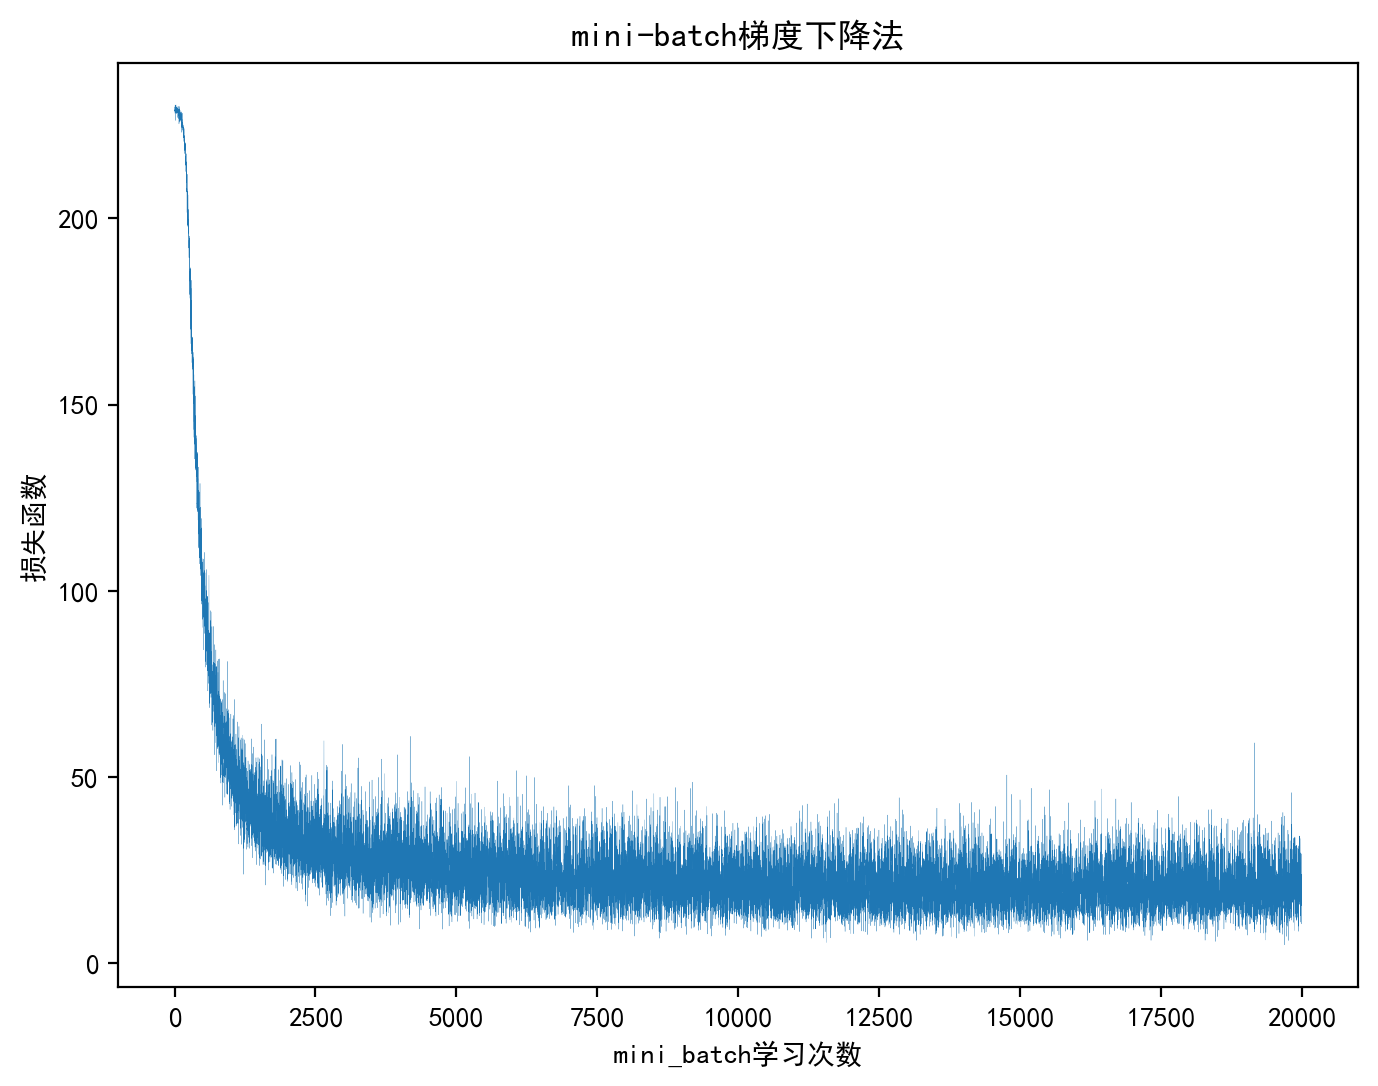

In [6]:
x = np.arange(len(train_loss_list))

plt.xlabel('mini_batch学习次数')
plt.ylabel('损失函数')
plt.title('mini-batch梯度下降法')
plt.plot(x,train_loss_list,lw=0.1)
plt.show()

In [7]:
#参数
w1 = network.params['W1']
b1 = network.params['b1']
w2 = network.params['W2']
b2 = network.params['b2']

print('第一层：')
print(f'**W1的系数为：{w1}')
print(f'****其shape为：{w1.shape}')
print('')
print(f'**b1的系数为：{b1}')
print(f'****其shape为：{b1.shape}')
print('')
print('第二层：')
print(f'**W2的系数为：{w2}')
print(f'****其shape为：{w2.shape}')
print('')
print(f'**b2的系数为：{b2}')
print(f'****其shape为：{b2.shape}')

第一层：
**W1的系数为：[[-0.01530953 -0.00440185  0.00894532 ... -0.01666509 -0.00717419
  -0.01875145]
 [ 0.00484865  0.00045476 -0.00610334 ... -0.01735734 -0.00362076
  -0.01021401]
 [-0.00344622 -0.00595918  0.00850357 ... -0.01523626 -0.00290936
  -0.00224318]
 ...
 [ 0.00593499  0.00788794 -0.0006785  ...  0.00551261  0.01518389
  -0.0149155 ]
 [ 0.0064104  -0.00949551  0.00200205 ... -0.00412855 -0.00089009
   0.00176105]
 [ 0.00936483  0.0140814   0.008144   ... -0.00594239 -0.01384135
   0.00588691]]
****其shape为：(784, 50)

**b1的系数为：[ 0.06470451 -0.19401328 -0.13341062 -0.0892119  -0.07386105  0.04682388
  0.12080014  0.19020556  0.15834918  0.06895429  0.02261254 -0.07641229
  0.16482103  0.05095005 -0.06526628 -0.01186749  0.01298317  0.03554412
  0.13976851 -0.08222471 -0.14588364 -0.13646942 -0.14873123  0.04594135
 -0.07246816  0.13800388 -0.13111272 -0.02496258  0.0598576  -0.09555285
  0.04046319  0.12962255 -0.04104101  0.01530605 -0.01989119 -0.00142118
  0.03046267  0.07629485